In [42]:
import numpy as np
import matplotlib.pyplot as plt
import particles
from particles import state_space_models as ssm
from scipy.stats import norm, t as student_t, invgamma
from copula_models import StudentFactorCopulaSSM,GaussianFactorCopulaSSM,GroupedStudentFactorCopulaSSM, simulate_copula_model_particles
from copula_u import StudentFactorCopulaSSM_U,GaussianFactorCopulaSSM_U,GroupedStudentFactorCopulaSSM_U, simulate_copula_model_U

np.random.seed(42)

Calcul profil Gaussien pour mu...
Calcul profil Gaussien pour phi...
Calcul profil Gaussien pour sigma...


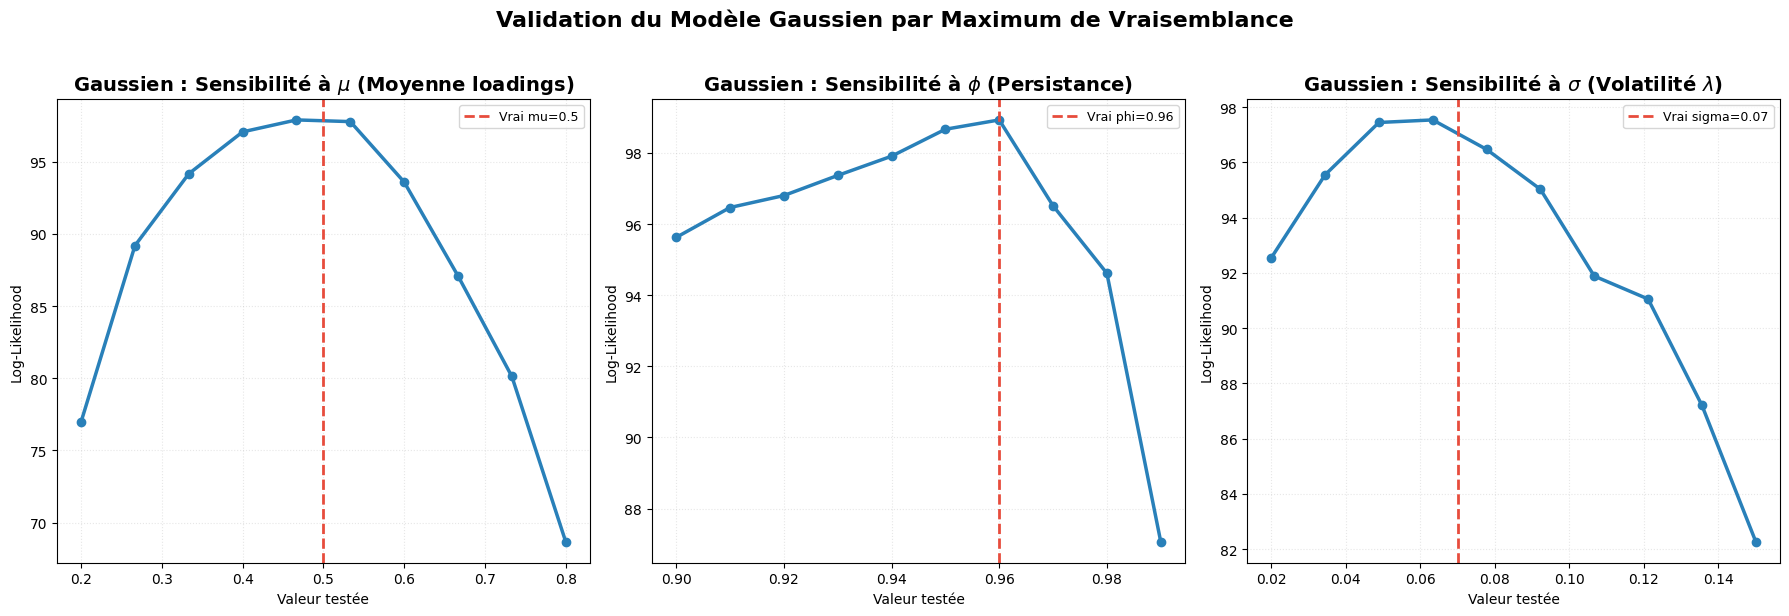

In [40]:
T, n_series, N_particles = 250, 10, 1500
# On définit les vrais paramètres Gaussiens (pas de nu ici)
true_params_gauss = {'mu': 0.5, 'phi': 0.96, 'sigma': 0.07}

model_gen = GaussianFactorCopulaSSM_U(n_series=n_series, n_factors=1, **true_params_gauss)
true_states, u_data = simulate_copula_model_U(model_gen, T)

# --- 2. FONCTION DE PROFIL DE VRAISEMBLANCE ---
def get_ll_profile_gauss(param_name, test_value):
    current_p = {**true_params_gauss, 'n_series': n_series, 'n_factors': 1}
    current_p[param_name] = test_value
    
    # Appel du modèle Gaussien qui traite les uniformes u_t
    model_test = GaussianFactorCopulaSSM_U(**current_p)
    fk = ssm.Bootstrap(ssm=model_test, data=u_data)
    
    # Utilisation du filtre particulaire pour estimer la LL
    pf = particles.SMC(fk=fk, N=1500, verbose=False)
    pf.run()
    return pf.logLt

# --- 3. CALCUL DES SCÉNARIOS (On teste mu, phi et sigma) ---
scenarios = {
    'mu':    (r'$\mu$ (Moyenne loadings)', np.linspace(0.2, 0.8, 10)),
    'phi':   (r'$\phi$ (Persistance)', np.linspace(0.90, 0.99, 10)),
    'sigma': (r'$\sigma$ (Volatilité $\lambda$)', np.linspace(0.02, 0.15, 10))
}

results = {}
for p_name, (label, vals) in scenarios.items():
    print(f"Calcul profil Gaussien pour {p_name}...")
    results[p_name] = [get_ll_profile_gauss(p_name, v) for v in vals]

# --- 4. GÉNÉRATION DES 3 PLOTS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)

for ax, (p_name, (label, vals)) in zip(axes, scenarios.items()):
    ax.plot(vals, results[p_name], 'o-', color='#2980b9', lw=2.5, ms=6)
    
    # Ligne verticale pour la vraie valeur
    ax.axvline(true_params_gauss[p_name], color='#e74c3c', ls='--', lw=2, 
               label=f'Vrai {p_name}={true_params_gauss[p_name]}')
    
    ax.set_title(f"Gaussien : Sensibilité à {label}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Valeur testée")
    ax.set_ylabel("Log-Likelihood")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, linestyle=':')

plt.suptitle("Validation du Modèle Gaussien par Maximum de Vraisemblance", 
             fontsize=16, y=1.02, fontweight='bold')

plt.tight_layout()
plt.show()

Calcul profil pour phi...
Calcul profil pour nu...
Calcul profil pour sigma...


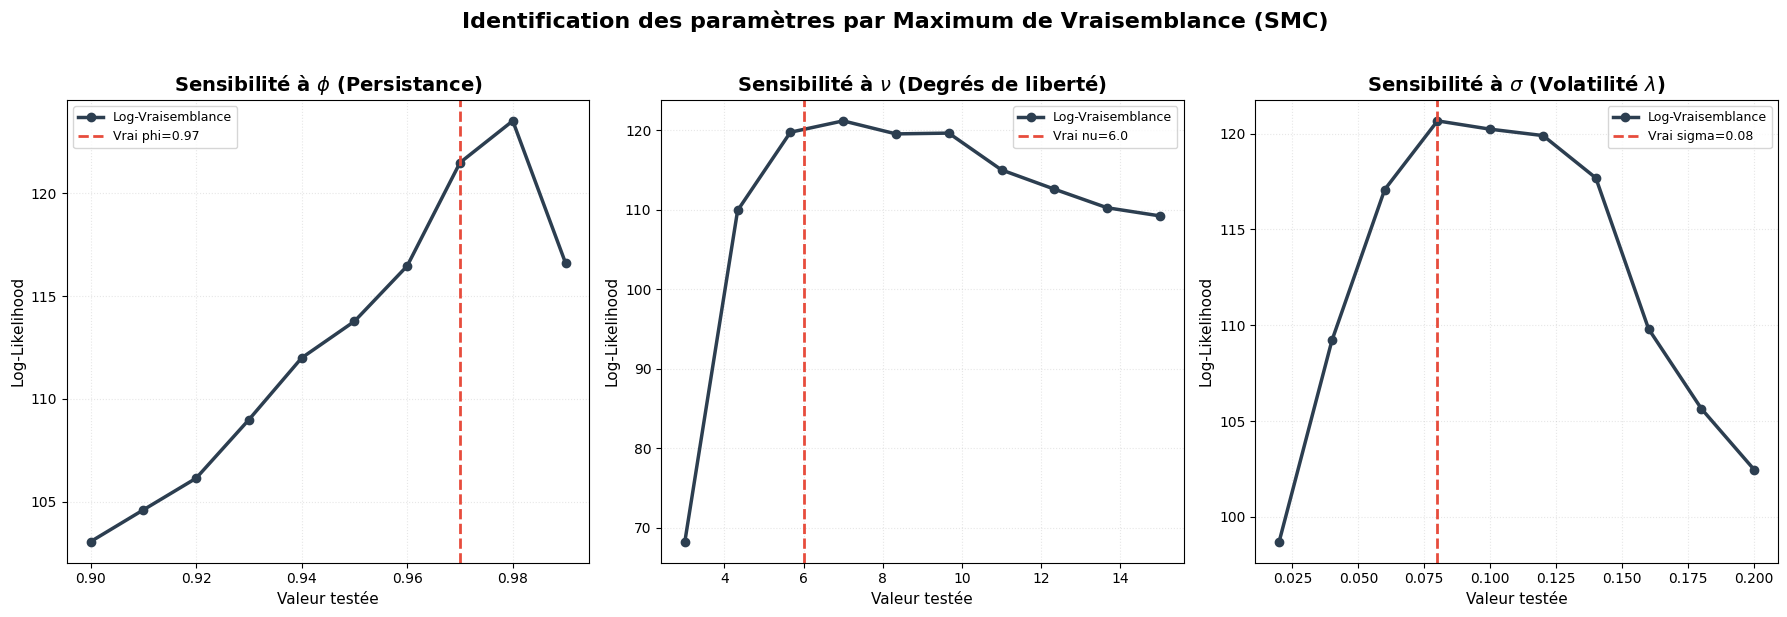

In [38]:
T, n_series, N_particles = 250, 10, 10000
true_params = {'mu': 0.4, 'phi': 0.97, 'sigma': 0.08, 'nu': 6.0}

model_gen = StudentFactorCopulaSSM_U(n_series=n_series, n_factors=1, **true_params)
true_states, u_data = simulate_copula_model_U(model_gen, T)

# --- 2. FONCTION DE PROFIL DE VRAISEMBLANCE ---
def get_ll_profile(param_name, test_value):
    current_p = {**true_params, 'n_series': n_series, 'n_factors': 1}
    current_p[param_name] = test_value
    model_test = StudentFactorCopulaSSM_U(**current_p)
    fk = ssm.Bootstrap(ssm=model_test, data=u_data)
    pf = particles.SMC(fk=fk, N=1500, verbose=False)
    pf.run()
    return pf.logLt

# --- 3. CALCUL DES SCÉNARIOS ---
scenarios = {
    'phi':   (r'$\phi$ (Persistance)', np.linspace(0.90, 0.99, 10)),
    'nu':    (r'$\nu$ (Degrés de liberté)', np.linspace(3, 15, 10)),
    'sigma': (r'$\sigma$ (Volatilité $\lambda$)', np.linspace(0.02, 0.20, 10))
}

results = {}
for p_name, (label, vals) in scenarios.items():
    print(f"Calcul profil pour {p_name}...")
    results[p_name] = [get_ll_profile(p_name, v) for v in vals]

# --- 4. GÉNÉRATION DES 3 PLOTS SÉPARÉS ---
# Nous créons une figure avec 1 ligne et 3 colonnes pour une meilleure lisibilité en slide
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)

for ax, (p_name, (label, vals)) in zip(axes, scenarios.items()):
    # Plot des points calculés
    ax.plot(vals, results[p_name], 'o-', color='#2c3e50', lw=2.5, ms=6, label='Log-Vraisemblance')
    
    # Ligne verticale pour la valeur réelle (cible)
    ax.axvline(true_params[p_name], color='#e74c3c', ls='--', lw=2, 
               label=f'Vrai {p_name}={true_params[p_name]}')
    
    ax.set_title(f"Sensibilité à {label}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Valeur testée", fontsize=11)
    ax.set_ylabel("Log-Likelihood", fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, linestyle=':')

plt.suptitle("Identification des paramètres par Maximum de Vraisemblance (SMC)", 
             fontsize=16, y=1.02, fontweight='bold')

plt.tight_layout()
plt.show()

Simulation Grouped Student terminée. Analyse des profils...
Calcul profil pour $\phi$ (Persistance)...
Calcul profil pour $\nu_1$ (Groupe 0)...
Calcul profil pour $\nu_2$ (Groupe 1)...


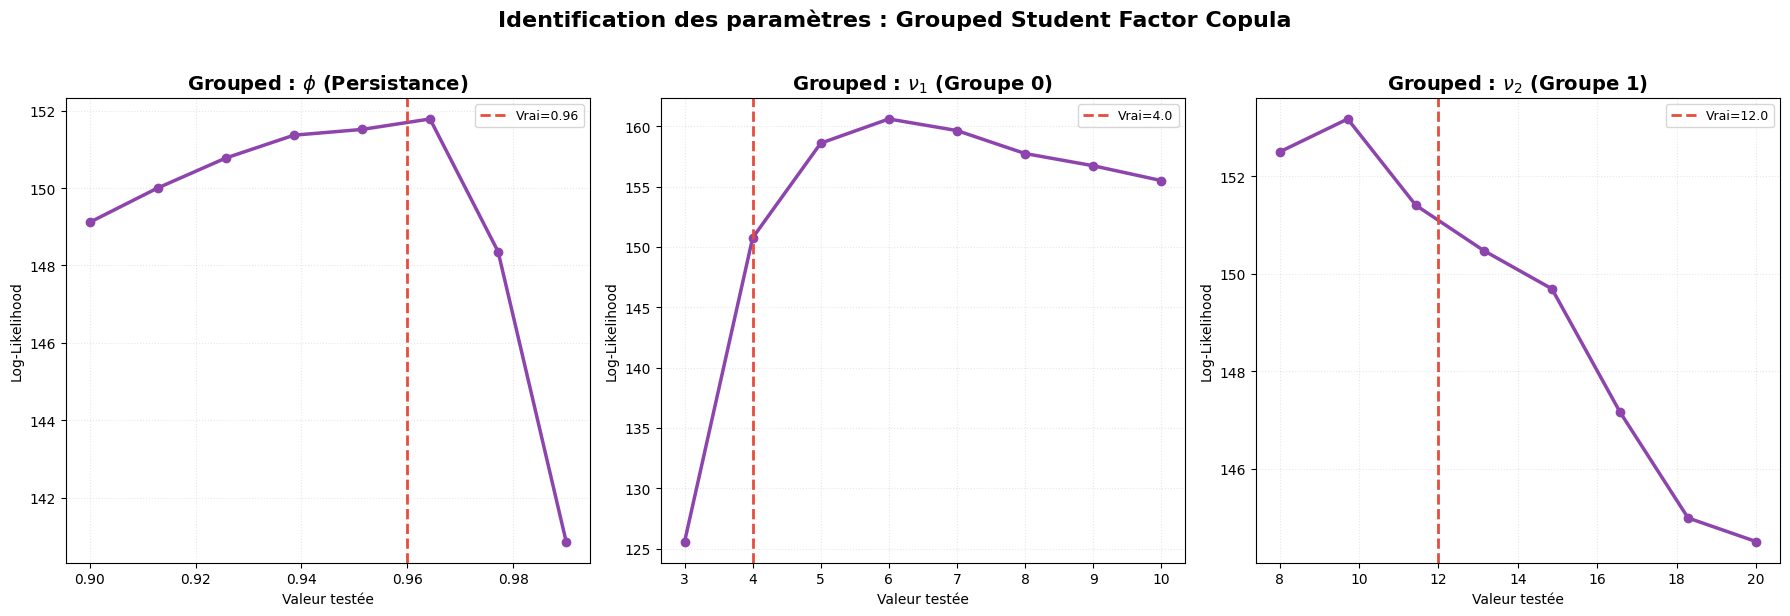

In [ ]:
# --- 1. CONFIGURATION ET SIMULATION DE RÉFÉRENCE (GROUPED) ---
T, n_series, N_particles = 250, 10, 10000
# On définit 2 groupes : le premier très risqué (nu=4), le second plus sage (nu=12)
true_params_grouped = {
    'mu': 0.5, 
    'phi': 0.96, 
    'sigma': 0.07, 
    'nus': [4.0, 12.0], # nu pour groupe 0 et groupe 1
    'n_groups': 2
}

model_gen = GroupedStudentFactorCopulaSSM_U(n_series=n_series, n_factors=1, **true_params_grouped)
true_states, u_data = simulate_copula_model_U(model_gen, T)

# --- 2. FONCTION DE PROFIL DE VRAISEMBLANCE ---
def get_ll_profile_grouped(param_name, test_value, group_idx=None):
    current_p = {**true_params_grouped, 'n_series': n_series, 'n_factors': 1}
    
    if param_name == 'nu_specific':
        # On modifie seulement le nu du groupe spécifié
        new_nus = list(current_p['nus'])
        new_nus[group_idx] = test_value
        current_p['nus'] = new_nus
    else:
        current_p[param_name] = test_value
    
    model_test = GroupedStudentFactorCopulaSSM_U(**current_p)
    fk = ssm.Bootstrap(ssm=model_test, data=u_data)
    
    pf = particles.SMC(fk=fk, N=1500, verbose=False)
    pf.run()
    return pf.logLt

# --- 3. CALCUL DES SCÉNARIOS ---
# On teste phi, nu_1 (groupe 0) et nu_2 (groupe 1)
scenarios = {
    'phi':       (r'$\phi$ (Persistance)', np.linspace(0.90, 0.99, 8), None),
    'nu_grp0':   (r'$\nu_1$ (Groupe 0)', np.linspace(3, 10, 8), 0),
    'nu_grp1':   (r'$\nu_2$ (Groupe 1)', np.linspace(8, 20, 8), 1)
}

results = {}
for p_key, (label, vals, g_idx) in scenarios.items():
    print(f"Calcul profil pour {label}...")
    if g_idx is not None:
        results[p_key] = [get_ll_profile_grouped('nu_specific', v, group_idx=g_idx) for v in vals]
    else:
        results[p_key] = [get_ll_profile_grouped(p_key, v) for v in vals]

# --- 4. GÉNÉRATION DES 3 PLOTS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)

for ax, (p_key, (label, vals, g_idx)) in zip(axes, scenarios.items()):
    ax.plot(vals, results[p_key], 'o-', color='#8e44ad', lw=2.5, ms=6)
    
    # Déterminer la vraie valeur pour la ligne verticale
    if g_idx is not None:
        vrai_val = true_params_grouped['nus'][g_idx]
    else:
        vrai_val = true_params_grouped[p_key]
        
    ax.axvline(vrai_val, color='#e74c3c', ls='--', lw=2, label=f'Vrai={vrai_val}')
    
    ax.set_title(f"Grouped : {label}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Valeur testée")
    ax.set_ylabel("Log-Likelihood")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, linestyle=':')

plt.suptitle("Identification des paramètres : Grouped Student Factor Copula", 
             fontsize=16, y=1.02, fontweight='bold')

plt.tight_layout()
plt.show()

In [46]:
# --- 1. CONFIGURATION ---
T, n_series = 100, 5 # Séries courtes pour accélérer le calcul
true_params = {'mu': 0.4, 'phi': 0.95, 'sigma': 0.1, 'nu': 5.0}
n_repeats = 20  # Nombre de fois qu'on relance le filtre pour calculer la variance
N_list = [100, 500, 1000, 2000, 5000] # Différentes valeurs de N à tester

# Simulation d'un dataset de référence
model_gen = StudentFactorCopulaSSM_U(n_series=n_series, **true_params)
_, u_data = simulate_copula_model_U(model_gen, T)

def compute_ll_variance(model_class, N_particles, data, repeats):
    ll_samples = []
    model = model_class(n_series=n_series, **true_params)
    fk = ssm.Bootstrap(ssm=model, data=data)
    
    for _ in range(repeats):
        pf = particles.SMC(fk=fk, N=N_particles, verbose=False)
        pf.run()
        ll_samples.append(pf.logLt)
    
    return np.var(ll_samples)

# --- 2. CALCULS ---
var_student = []
var_gaussian = []

print("Calcul de la variance en fonction de N...")
for N in N_list:
    print(f"  Test pour N = {N}")
    var_student.append(compute_ll_variance(StudentFactorCopulaSSM_U, N, u_data, n_repeats))
    var_gaussian.append(compute_ll_variance(GaussianFactorCopulaSSM_U, N, u_data, n_repeats))

# --- 3. GÉNÉRATION DU GRAPHIQUE ---
plt.figure(figsize=(10, 6))

plt.plot(N_list, var_student, 'o-', label='Copule Student', color='#e74c3c', lw=2)
plt.plot(N_list, var_gaussian, 's-', label='Copule Gaussienne', color='#3498db', lw=2)

# Optionnel : Tracer la courbe théorique 1/N pour comparer
theoretical_trend = [var_student[0] * (N_list[0]/n) for n in N_list]
plt.plot(N_list, theoretical_trend, '--', color='gray', alpha=0.5, label='Tendance théorique $1/N$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Nombre de particules (N)', fontsize=12)
plt.ylabel('Variance de la Log-Vraisemblance', fontsize=12)
plt.title('Convergence de l\'estimateur SMC : Variance vs N', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

Calcul de la variance en fonction de N...
  Test pour N = 100


TypeError: GaussianFactorCopulaSSM_U.__init__() got an unexpected keyword argument 'nu'

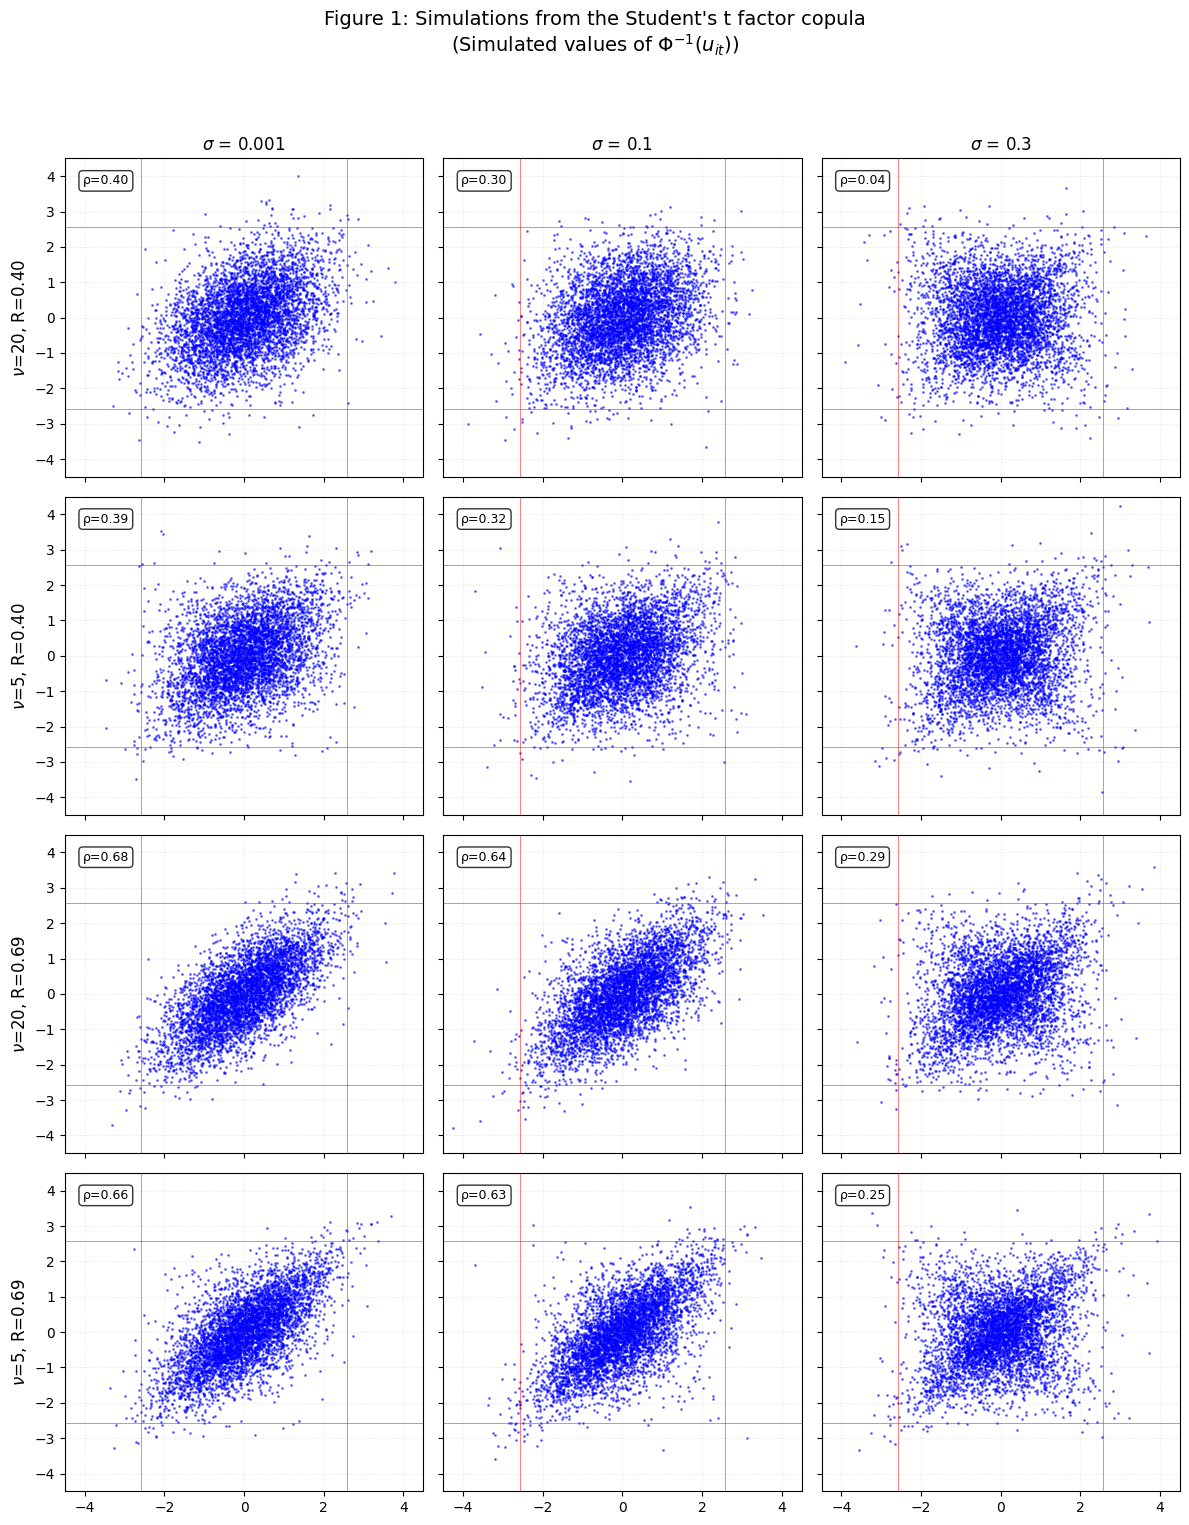

In [28]:
T = 5000
n_series = 2  # Copule bivariée

# Colonnes : différentes valeurs de sigma (volatilité des loadings)
sigmas = [0.001, 0.1, 0.3]  # 0.001 au lieu de 0 pour éviter des problèmes numériques

# Lignes : combinaisons de (nu, R)
# R = corrélation cible, on en déduit mu (mean des loadings)
# Relation : R ≈ λ² / (1 + λ²) => λ = sqrt(R / (1-R))
rows_params = [
    {'nu': 20, 'R': 0.4},   # Ligne 1
    {'nu': 5,  'R': 0.4},   # Ligne 2
    {'nu': 20, 'R': 0.69},  # Ligne 3
    {'nu': 5,  'R': 0.69}   # Ligne 4
]

def correlation_to_loading(R):
    """Convertit une corrélation cible en loading moyen."""
    return np.sqrt(R / (1 - R))

# Lignes de référence (quantiles 0.5% et 99.5%)
ref_lines = norm.ppf([0.005, 0.995])

# Création de la figure
fig, axes = plt.subplots(4, 3, figsize=(12, 16), sharex=True, sharey=True)

for i, row_cfg in enumerate(rows_params):
    nu = row_cfg['nu']
    R = row_cfg['R']
    mu = correlation_to_loading(R)
    
    for j, sig in enumerate(sigmas):
        ax = axes[i, j]
        
        # Création du modèle avec les paramètres appropriés
        model = StudentFactorCopulaSSM(
            n_series=n_series,
            n_factors=1,
            mu=mu,
            phi=0.98,        # Haute persistance comme dans l'article
            sigma=sig,
            nu=nu
        )
        
        # Simulation
        true_states, data = simulate_copula_model_particles(model, T)
        
        # Transformation en Uniforme puis en Normal standard
        # Les données sont déjà standardisées par simulate_copula_model
        # On applique la CDF Student puis l'inverse Normal
        from scipy.stats import t as student_t
        
        # CDF Student pour obtenir les uniformes
        U = student_t.cdf(data, df=nu)
        U = np.clip(U, 1e-9, 1 - 1e-9)
        
        # Inverse Normal pour obtenir Φ^{-1}(u)
        X_norm = norm.ppf(U)
        
        # Plot Scatter
        ax.scatter(X_norm[:, 0], X_norm[:, 1], s=1, alpha=0.5, color='blue')
        
        # Lignes de référence
        for ref in ref_lines:
            ax.axhline(ref, color='red', linewidth=0.5, alpha=0.7)
            ax.axvline(ref, color='red', linewidth=0.5, alpha=0.7)
        
        ax.set_xlim(-4.5, 4.5)
        ax.set_ylim(-4.5, 4.5)
        
        # Titres
        if i == 0:
            ax.set_title(f"$\sigma$ = {sig}", fontsize=12)
        if j == 0:
            ax.set_ylabel(f"$\\nu$={nu}, R={R:.2f}", fontsize=12)
        
        ax.grid(True, linestyle=':', alpha=0.3)
        
        # Calcul de la corrélation empirique pour vérification
        corr_emp = np.corrcoef(X_norm[:, 0], X_norm[:, 1])[0, 1]
        ax.text(0.05, 0.95, f"ρ={corr_emp:.2f}", transform=ax.transAxes, 
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle("Figure 1: Simulations from the Student's t factor copula\n"
             "(Simulated values of $\Phi^{-1}(u_{it})$)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

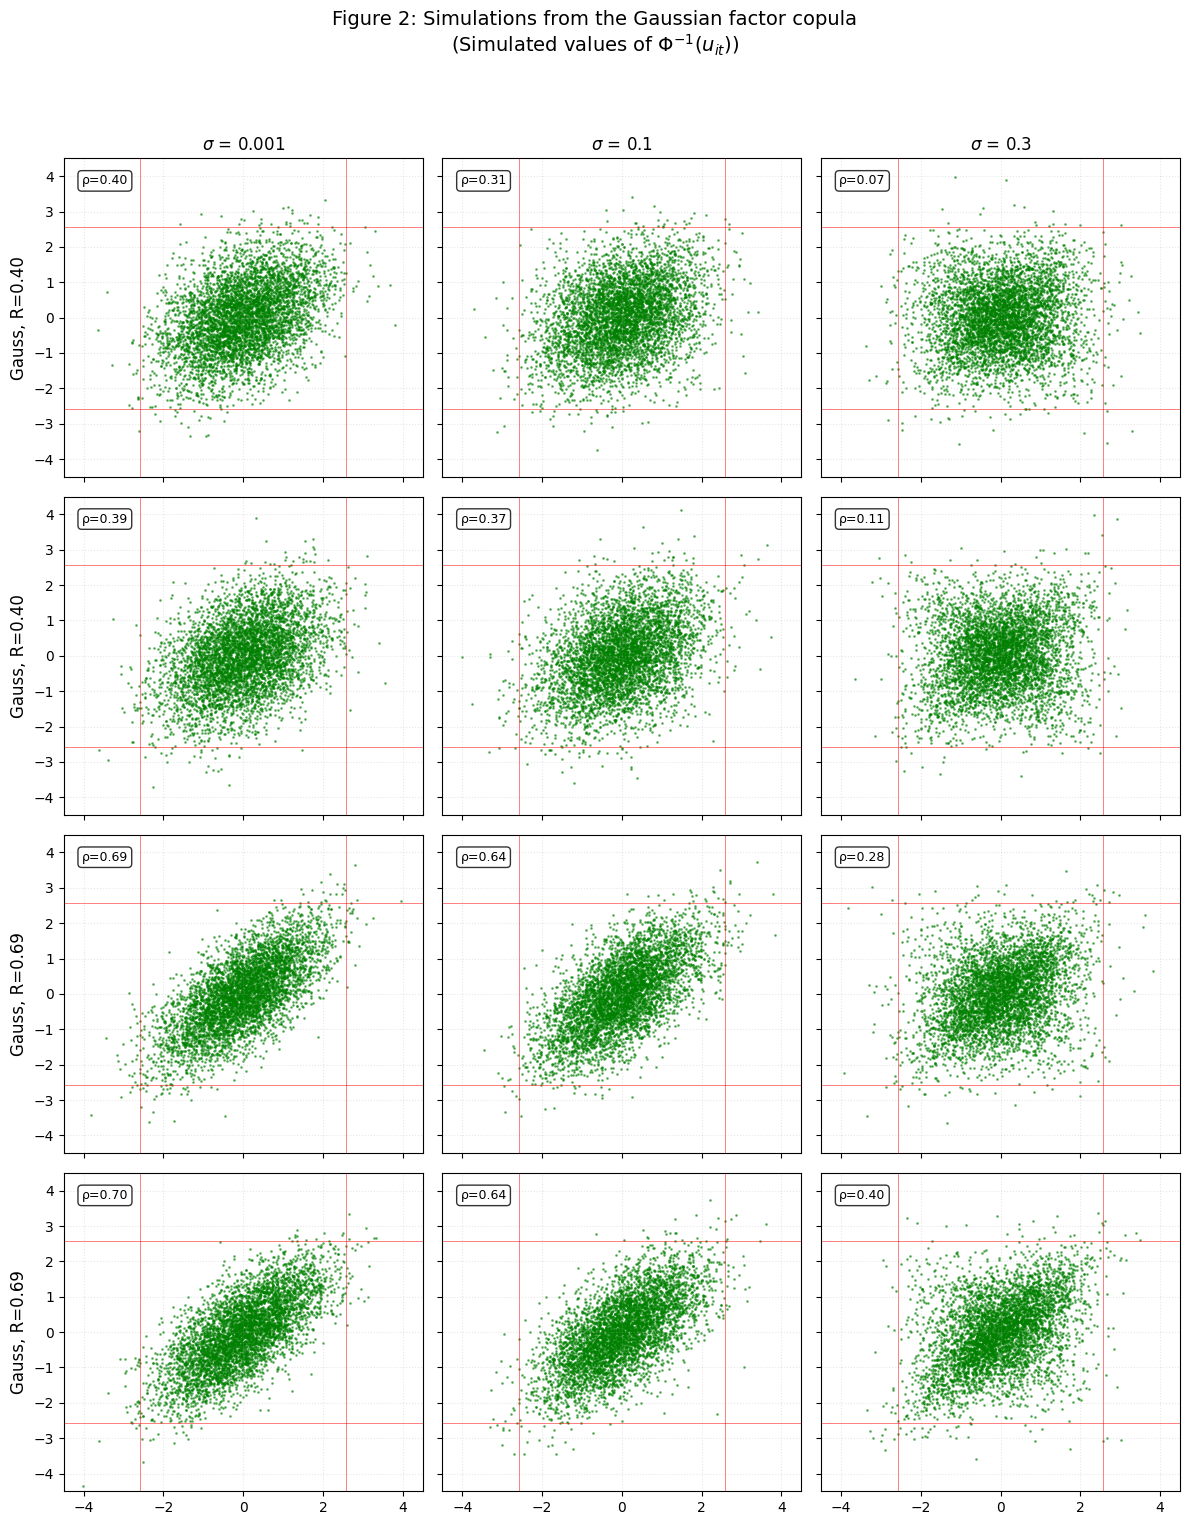

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Hypothèse : La classe GaussianFactorCopulaSSM est déjà chargée depuis vos imports précédents.
# Si ce n'est pas le cas, assurez-vous d'avoir exécuté le bloc définissant les classes.

T = 5000
n_series = 2

# Colonnes : volatilité des loadings
sigmas = [0.001, 0.1, 0.3]

# Lignes : Corrélation cible R (Nu est ignoré ici car on est en Gaussien)
rows_params = [
    {'nu': 'Inf', 'R': 0.4},   # Ligne 1 (Equivalent Nu=20 Student)
    {'nu': 'Inf', 'R': 0.4},   # Ligne 2 (Equivalent Nu=5 Student) -> Sera identique à la ligne 1
    {'nu': 'Inf', 'R': 0.69},  # Ligne 3 (Equivalent Nu=20 Student)
    {'nu': 'Inf', 'R': 0.69}   # Ligne 4 (Equivalent Nu=5 Student) -> Sera identique à la ligne 3
]

def correlation_to_loading(R):
    """Relation R = lambda^2 / (1 + lambda^2)"""
    return np.sqrt(R / (1 - R))

# Lignes de référence (quantiles 0.5% et 99.5%)
ref_lines = norm.ppf([0.005, 0.995])

fig, axes = plt.subplots(4, 3, figsize=(12, 16), sharex=True, sharey=True)

for i, row_cfg in enumerate(rows_params):
    R = row_cfg['R']
    mu = correlation_to_loading(R)
    
    for j, sig in enumerate(sigmas):
        ax = axes[i, j]
        
        # 1. Création du modèle GAUSSIEN
        # Note : 'nu' n'est pas passé car la classe Gaussian ne l'utilise pas
        model = GaussianFactorCopulaSSM(
            n_series=n_series,
            n_factors=1,
            mu=mu,
            phi=0.98,
            sigma=sig
        )
        
        # 2. Simulation
        # true_states ignoré ici
        _, data = simulate_copula_model_particles(model, T)
        
        # 3. Transformation : Simulation -> Uniforme -> Normale
        # Pour une copule Gaussienne, les données latentes 'data' sont déjà N(0,1).
        # Mathématiquement, X_norm sera quasi identique à 'data'.
        # On fait la transformation explicite pour respecter la logique Copule.
        
        # A. Vers Uniforme (via CDF Normale)
        U = norm.cdf(data)
        U = np.clip(U, 1e-9, 1 - 1e-9)
        
        # B. Vers Quantiles Normaux (via Inverse Normale)
        X_norm = norm.ppf(U)
        
        # Plot Scatter
        ax.scatter(X_norm[:, 0], X_norm[:, 1], s=1, alpha=0.5, color='green') # Vert pour distinguer
        
        # Lignes de référence
        for ref in ref_lines:
            ax.axhline(ref, color='red', linewidth=0.5, alpha=0.7)
            ax.axvline(ref, color='red', linewidth=0.5, alpha=0.7)
        
        ax.set_xlim(-4.5, 4.5)
        ax.set_ylim(-4.5, 4.5)
        
        # Titres
        if i == 0:
            ax.set_title(f"$\sigma$ = {sig}", fontsize=12)
        if j == 0:
            ax.set_ylabel(f"Gauss, R={R:.2f}", fontsize=12)
        
        ax.grid(True, linestyle=':', alpha=0.3)
        
        # Corrélation empirique
        corr_emp = np.corrcoef(X_norm[:, 0], X_norm[:, 1])[0, 1]
        ax.text(0.05, 0.95, f"ρ={corr_emp:.2f}", transform=ax.transAxes, 
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle("Figure 2: Simulations from the Gaussian factor copula\n"
             "(Simulated values of $\Phi^{-1}(u_{it})$)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Test de stabilité (50 runs)...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


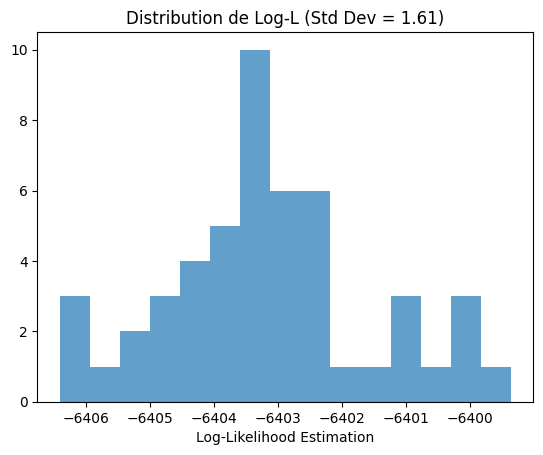

In [29]:
n_repeats = 50
ll_samples = []

print(f"Test de stabilité ({n_repeats} runs)...")
for i in range(n_repeats):
    pf = particles.SMC(fk=fk, N=N_particles, verbose=False)
    pf.run()
    ll_samples.append(pf.logLt)
    print(i)

std_ll = np.std(ll_samples)
plt.hist(ll_samples, bins=15, alpha=0.7)
plt.title(f"Distribution de Log-L (Std Dev = {std_ll:.2f})")
plt.xlabel("Log-Likelihood Estimation")
# Règle empirique: si Std > 1.5, augmentez N_particles
plt.show()